In [1]:
from glucose_dataset import GlucoseDataset
from models import GlucoseModel
from snntorch import spikeplot as splt, spikegen
import torch
import matplotlib.pyplot as plt

input_samples = 8
output_samples = 8
steps = 250

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [2]:
ds = GlucoseDataset("datasets/diabetes_datasets.zip", sub_directory="Shanghai_T1DM")

In [3]:
net = GlucoseModel(input_samples, 16, output_samples).to(device)

In [4]:
sample = ds.__getitem__(0)
inputs = sample[:input_samples].to(device)
targets = sample[input_samples:input_samples*2].to(device)
spk_in = spikegen.rate(inputs/steps, num_steps=steps)
spk_out, mem_out = net(inputs, steps=steps)

RuntimeError: both arguments to matmul need to be at least 1D, but they are 0D and 2D

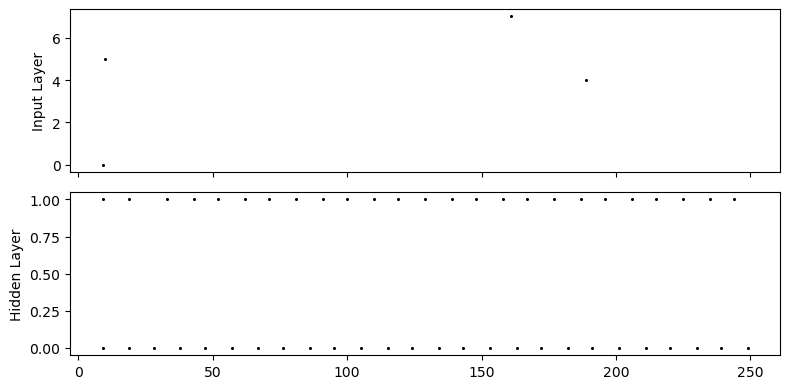

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
splt.raster(spk_in, axs[0], s=1.5, c="black")
axs[0].set_ylabel("Input Layer")
splt.raster(spk_out, axs[1], s=1.5, c="black")
axs[1].set_ylabel("Hidden Layer");
plt.tight_layout()

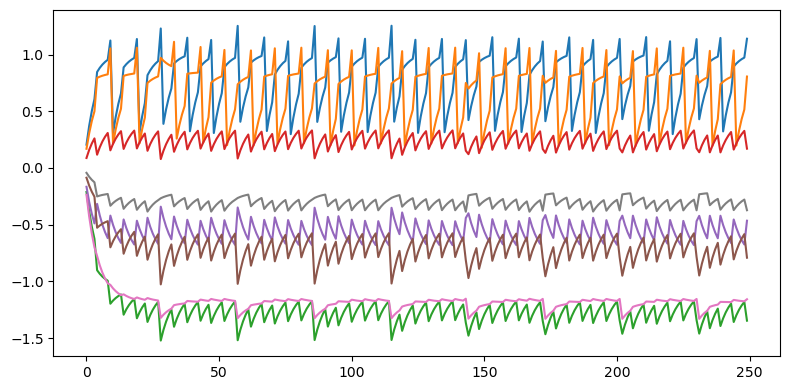

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(mem_out.detach().cpu().numpy());
plt.tight_layout()

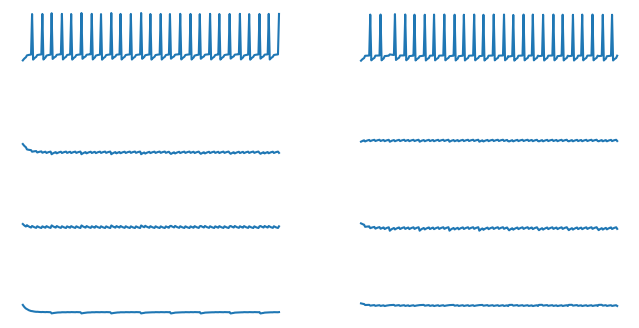

In [ ]:
splt.traces(mem_out.squeeze(1), spk=spk_out.squeeze(1), dim=(4,2))
fig = plt.gcf()
fig.set_size_inches(8, 4)